# Import libs

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.nn import ModuleList
from torch import nn
import torch.optim as optim

# custom libs
from libs.PretrainedModels import AlexNet_cc, SqueezeNet_cc, InceptionV3_cc
from libs.utils import get_model_name, import_dataset, reverse_norm, init_model

In [2]:
random.seed(1996)
np.random.seed(1996)

# Prepare dataset

In [3]:
path_dst = 'dataset'
path_gdrive = ''

# parameters for dataloaders
batch_size=32
num_workers=2
drop_last=True

# default mean and std needed by pretrained models from pytorch
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

## Dataset for alexnet and squeezenet

In [4]:
dst = import_dataset(path_dst=path_dst, 
    train_transform=transforms.Compose([
        transforms.Resize(256),
        # using the same as the test because the trash bin is centered in the image
        transforms.CenterCrop(224), # good for inceptionv3?
        transforms.RandomApply(ModuleList([
            transforms.ColorJitter(brightness=.3, hue=.2),
        ]), p=0.3),

        transforms.RandomApply(ModuleList([
            transforms.Grayscale(num_output_channels=3),
        ]), p=0.2),

        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomPerspective(distortion_scale=0.3, p=0.2),
        transforms.RandomEqualize(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    test_transform=transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), # good for inceptionv3?
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]), path_gdrive=path_gdrive)

dst.create_data_loader(batch_size=batch_size, num_workers=num_workers, drop_last=drop_last)

### Visualize dataset

Training

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


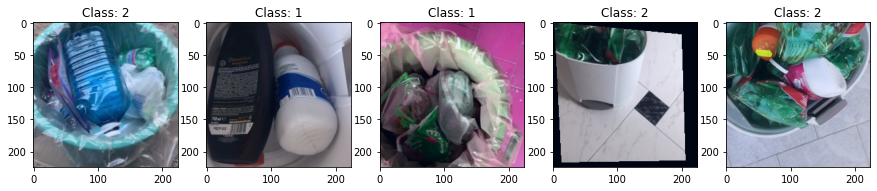

In [5]:
train_features, train_labels = next(iter(dst.training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    train_features, train_labels = next(iter(dst.training_loader))
plt.show()

Test

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


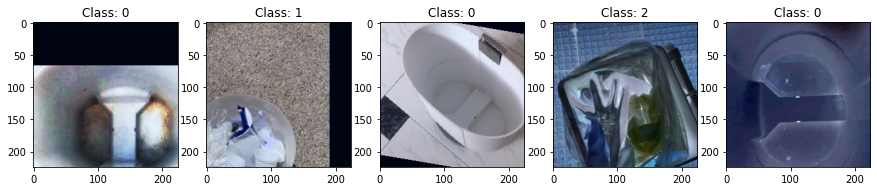

In [6]:
train_features, train_labels = next(iter(dst.test_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    train_features, train_labels = next(iter(dst.test_loader))
plt.show()

## Dataset for inceptionv3

In [6]:
dst_inceptionv3 = import_dataset(path_dst=path_dst, 
    train_transform=transforms.Compose([
        transforms.Resize(320),
        # using the same as the test because the trash bin is centered in the image
        transforms.CenterCrop(299), # good for inceptionv3?
        transforms.RandomApply(ModuleList([
            transforms.ColorJitter(brightness=.3, hue=.2),
        ]), p=0.3),

        transforms.RandomApply(ModuleList([
            transforms.Grayscale(num_output_channels=3),
        ]), p=0.2),

        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomPerspective(distortion_scale=0.3, p=0.2),
        transforms.RandomEqualize(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]),
    test_transform=transforms.Compose([
        transforms.Resize(320), 
        transforms.CenterCrop(299), # good for inceptionv3?
        transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ]), path_gdrive=path_gdrive)

dst_inceptionv3.create_data_loader(batch_size=batch_size, num_workers=num_workers, drop_last=drop_last)

### Visualize dataset

Training

Feature batch shape: torch.Size([32, 3, 299, 299])
Labels batch shape: torch.Size([32])


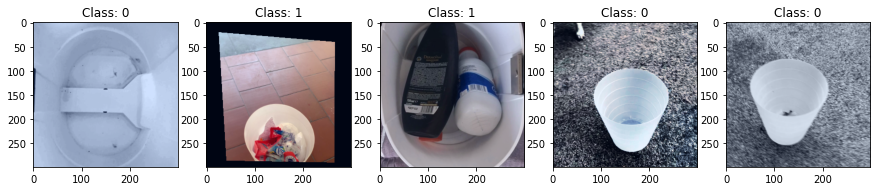

In [9]:
train_features, train_labels = next(iter(dst_inceptionv3.training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    train_features, train_labels = next(iter(dst_inceptionv3.training_loader))
plt.show()

Test

Feature batch shape: torch.Size([32, 3, 299, 299])
Labels batch shape: torch.Size([32])


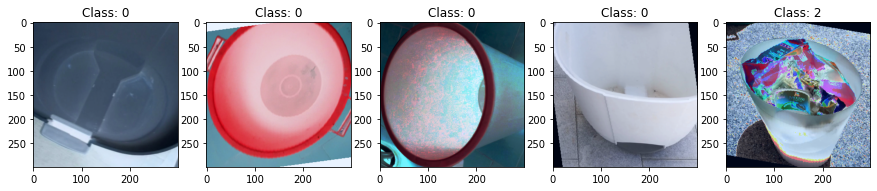

In [10]:
train_features, train_labels = next(iter(dst_inceptionv3.test_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    train_features, train_labels = next(iter(dst_inceptionv3.test_loader))
plt.show()

# Find best LR

In [7]:
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()

In [ ]:
## da sostituire le var sotto
optim_lr = 0.0001
momentum = 0.99
end_lr = 0.01
num_iter = 100

### Finding best lr for squeezenet

In [8]:
squeezenet = init_model(creator=SqueezeNet_cc(), model_name='SqueezeNet', feature_extract=True, use_pretrained=True)
squeezenet = squeezenet.ret_model()

optimizer = optim.SGD(squeezenet.parameters(), lr=optim_lr, momentum=momentum)

Initializing: SqueezeNet


100%|██████████| 100/100 [3:11:31<00:00, 114.92s/it]


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.10E-03


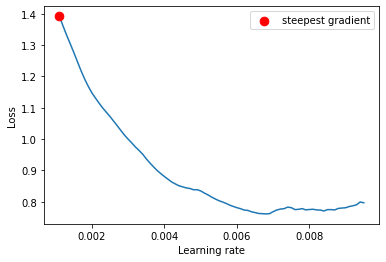

In [9]:
lr_finder = LRFinder(squeezenet, optimizer, criterion)
lr_finder.range_test(train_loader=dst.training_loader, val_loader=dst.validation_loader, end_lr=end_lr, num_iter=num_iter, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

Suggested lr is `0.00191`

### Finding best lr for inception

In [7]:
inceptionv3 = init_model(creator=InceptionV3_cc(), model_name='InceptionV3', feature_extract=True, use_pretrained=True)
inceptionv3 = inceptionv3.ret_model()
# disable the aux branch, in this way the forward function will not return a tuple
inceptionv3.aux_logits=False
optimizer = optim.SGD(inceptionv3.parameters(), lr=0.001, momentum=0.9)

Initializing: InceptionV3


In [10]:
lr_finder = LRFinder(inceptionv3, optimizer, criterion)

lr_finder.range_test(train_loader=dst_inceptionv3.training_loader, val_loader=dst_inceptionv3.validation_loader, end_lr=0.01, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

 71%|███████   | 71/100 [2:51:41<1:17:38, 160.65s/it]